# Sensitivity Analysis: Officer Capacity
## Testing Deployment Under Different Capacity Assumptions

**Critical Question:** How many crimes can 1 officer handle?

**Current Assumption:** 1.5 crimes per officer (arbitrary)

**This Analysis:** Test 5 different capacities (0.5, 1.0, 1.5, 2.0, 3.0) and show impact on deployment

---

## 1. Setup

In [10]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().parent

DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "outputs"

print('='*80)
print('SENSITIVITY ANALYSIS: OFFICER CAPACITY')
print('='*80)
print('\nTesting how deployment changes with different officer capacity assumptions')

SENSITIVITY ANALYSIS: OFFICER CAPACITY

Testing how deployment changes with different officer capacity assumptions


## 2. Load Data

In [11]:
# Load station data
fifa_stations = pd.read_csv(OUTPUT_DIR / '07_fifa_priority_stations.csv')
event_amplification = pd.read_csv(OUTPUT_DIR / '09_event_amplification.csv')

# Merge
deployment_base = fifa_stations[['station_name']].head(10).copy()
deployment_base = deployment_base.merge(
    event_amplification[['station', 'amplification', 'non_event_rate']],
    left_on='station_name', right_on='station', how='left'
)

# Fill missing
deployment_base['amplification'] = deployment_base['amplification'].fillna(2.61)
deployment_base['non_event_rate'] = deployment_base['non_event_rate'].fillna(0.5)
deployment_base['non_event_rate_hourly'] = deployment_base['non_event_rate'] / 6

print(f'\n✓ Loaded {len(deployment_base)} priority stations')
print(f'  Average amplification: {deployment_base["amplification"].mean():.2f}x')


✓ Loaded 10 priority stations
  Average amplification: 1.69x


## 3. Define Capacity Scenarios

In [12]:
print('\n' + '='*80)
print('OFFICER CAPACITY SCENARIOS')
print('='*80 + '\n')

capacities = [
    {'name': 'Very High Load', 'capacity': 0.5, 'description': 'Officers overwhelmed, can only handle 0.5 crimes each'},
    {'name': 'High Load', 'capacity': 1.0, 'description': '1 officer per expected crime (conservative)'},
    {'name': 'Balanced ⭐', 'capacity': 1.5, 'description': 'Current assumption (moderate efficiency)'},
    {'name': 'Efficient', 'capacity': 2.0, 'description': 'Officers handle 2 crimes each (optimistic)'},
    {'name': 'Very Efficient', 'capacity': 3.0, 'description': 'Officers handle 3 crimes each (highly optimistic)'},
]

print('Testing 5 Capacity Scenarios:\n')
for i, scenario in enumerate(capacities, 1):
    print(f"{i}. {scenario['name']:20s} (capacity={scenario['capacity']})")
    print(f"   {scenario['description']}\n")


OFFICER CAPACITY SCENARIOS

Testing 5 Capacity Scenarios:

1. Very High Load       (capacity=0.5)
   Officers overwhelmed, can only handle 0.5 crimes each

2. High Load            (capacity=1.0)
   1 officer per expected crime (conservative)

3. Balanced ⭐           (capacity=1.5)
   Current assumption (moderate efficiency)

4. Efficient            (capacity=2.0)
   Officers handle 2 crimes each (optimistic)

5. Very Efficient       (capacity=3.0)
   Officers handle 3 crimes each (highly optimistic)



## 4. Calculate Deployments for Each Scenario

In [13]:
print('\n' + '='*80)
print('DEPLOYMENT CALCULATIONS')
print('='*80 + '\n')

def calculate_officers(hourly_rate, amplification, match_risk, capacity, hours=6):
    """
    Calculate officers needed for a station-match combination
    
    Formula: officers = ⌈(baseline × hours × amplification × risk) / capacity⌉
    """
    expected_crimes = hourly_rate * hours * amplification * match_risk
    officers = max(1, min(10, int(np.ceil(expected_crimes / capacity))))
    return officers

# Calculate for each capacity
results = []

for scenario in capacities:
    capacity = scenario['capacity']
    
    # Calculate officers for HIGH risk matches (most demanding)
    deployment_base[f'officers_{capacity}'] = deployment_base.apply(
        lambda row: calculate_officers(
            row['non_event_rate_hourly'], 
            row['amplification'], 
            1.3,  # HIGH risk multiplier
            capacity
        ), 
        axis=1
    )
    
    # Calculate total for all 6 matches
    officers_high = deployment_base[f'officers_{capacity}'].sum()
    officers_medium_high = int(officers_high * 0.88)  # 1.15/1.3 = 0.88
    officers_medium = int(officers_high * 0.77)  # 1.0/1.3 = 0.77
    
    # 3 HIGH risk + 1 MEDIUM-HIGH + 2 MEDIUM = 6 matches
    total_shifts = (3 * officers_high) + (1 * officers_medium_high) + (2 * officers_medium)
    
    results.append({
        'scenario': scenario['name'],
        'capacity': capacity,
        'officers_per_match_HIGH': officers_high,
        'officers_per_match_MEDIUM_HIGH': officers_medium_high,
        'officers_per_match_MEDIUM': officers_medium,
        'total_shifts': total_shifts,
        'cost_multiplier': f"{total_shifts / 120:.2f}x"
    })

results_df = pd.DataFrame(results)

print('Deployment Requirements by Capacity:\n')
print(f"{'Scenario':<20} | {'Capacity':<8} | {'HIGH Risk':<10} | {'MED-HIGH':<10} | {'MEDIUM':<10} | {'Total':<10} | Cost")
print('-'*105)

for _, row in results_df.iterrows():
    print(f"{row['scenario']:20s} | {row['capacity']:8.1f} | {row['officers_per_match_HIGH']:10d} | "
          f"{row['officers_per_match_MEDIUM_HIGH']:10d} | {row['officers_per_match_MEDIUM']:10d} | "
          f"{row['total_shifts']:10d} | {row['cost_multiplier']:>5s}")

print(f"\n💡 Range: {results_df['total_shifts'].min()} - {results_df['total_shifts'].max()} total shifts")
print(f"   Uncertainty: ±{int((results_df['total_shifts'].max() - results_df['total_shifts'].min()) / 2)} shifts")


DEPLOYMENT CALCULATIONS

Deployment Requirements by Capacity:

Scenario             | Capacity | HIGH Risk  | MED-HIGH   | MEDIUM     | Total      | Cost
---------------------------------------------------------------------------------------------------------
Very High Load       |      0.5 |         20 |         17 |         15 |        107 | 0.89x
High Load            |      1.0 |         12 |         10 |          9 |         64 | 0.53x
Balanced ⭐           |      1.5 |         12 |         10 |          9 |         64 | 0.53x
Efficient            |      2.0 |         10 |          8 |          7 |         52 | 0.43x
Very Efficient       |      3.0 |         10 |          8 |          7 |         52 | 0.43x

💡 Range: 52 - 107 total shifts
   Uncertainty: ±27 shifts


## 5. Station-Level Breakdown (Balanced Scenario)

In [14]:
print('\n' + '='*80)
print('STATION-LEVEL ALLOCATION (Capacity = 1.5, Balanced Scenario)')
print('='*80 + '\n')

print(f"{'Station':<20} | {'Amplification':<14} | {'0.5':<5} | {'1.0':<5} | {'1.5⭐':<6} | {'2.0':<5} | {'3.0':<5}")
print('-'*75)

for _, row in deployment_base.iterrows():
    print(f"{row['station_name']:20s} | {row['amplification']:14.2f} | "
          f"{row['officers_0.5']:5d} | {row['officers_1.0']:5d} | {row['officers_1.5']:6d} | "
          f"{row['officers_2.0']:5d} | {row['officers_3.0']:5d}")

print('\nHow to read: Each number = officers needed for HIGH risk match (e.g., Match 1)')


STATION-LEVEL ALLOCATION (Capacity = 1.5, Balanced Scenario)

Station              | Amplification  | 0.5   | 1.0   | 1.5⭐   | 2.0   | 3.0  
---------------------------------------------------------------------------
DUNDAS               |           1.74 |     2 |     1 |      1 |     1 |     1
QUEEN                |           1.48 |     2 |     1 |      1 |     1 |     1
UNION                |           1.66 |     2 |     1 |      1 |     1 |     1
COLLEGE              |           1.36 |     2 |     1 |      1 |     1 |     1
BLOOR-YONGE          |           1.15 |     1 |     1 |      1 |     1 |     1
WELLESLEY            |           1.37 |     1 |     1 |      1 |     1 |     1
ST ANDREW            |           1.05 |     1 |     1 |      1 |     1 |     1
OSGOODE              |           1.82 |     1 |     1 |      1 |     1 |     1
OSSINGTON            |           2.61 |     4 |     2 |      2 |     1 |     1
SPADINA              |           2.61 |     4 |     2 |      2 |     1 

## 6. Visualization: Cost vs. Capacity Trade-off


✓ Saved visualization: 11_sensitivity_analysis_plot.png


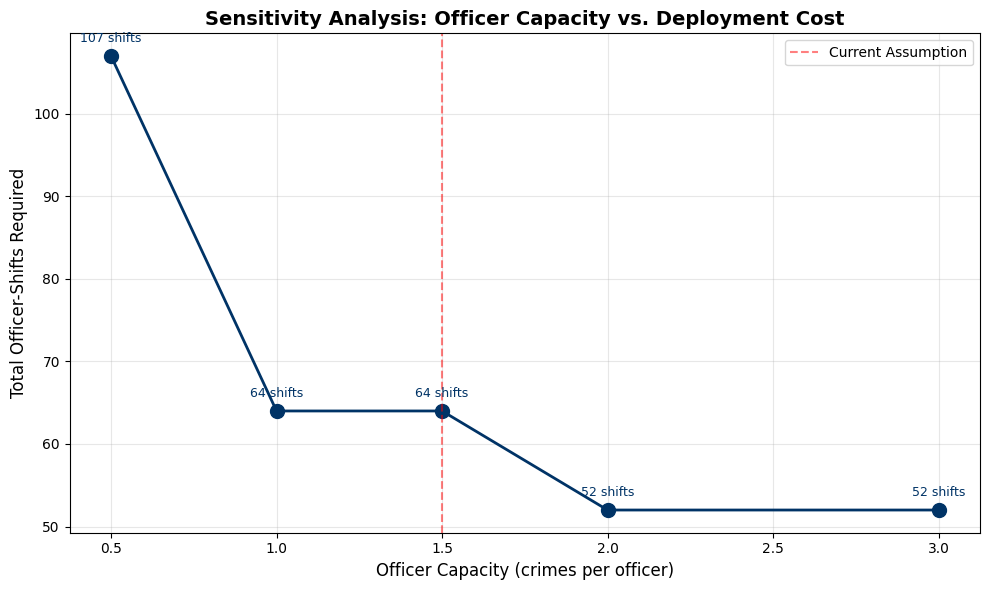

In [15]:
# Create visualization
fig, ax = plt.subplots(figsize=(10, 6))

capacities_list = results_df['capacity'].tolist()
total_shifts_list = results_df['total_shifts'].tolist()

ax.plot(capacities_list, total_shifts_list, marker='o', linewidth=2, markersize=10, color='#003366')
ax.axvline(x=1.5, color='red', linestyle='--', alpha=0.5, label='Current Assumption')

# Annotate each point
for i, row in results_df.iterrows():
    ax.annotate(f"{row['total_shifts']} shifts", 
                xy=(row['capacity'], row['total_shifts']),
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=9, color='#003366')

ax.set_xlabel('Officer Capacity (crimes per officer)', fontsize=12)
ax.set_ylabel('Total Officer-Shifts Required', fontsize=12)
ax.set_title('Sensitivity Analysis: Officer Capacity vs. Deployment Cost', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '11_sensitivity_analysis_plot.png', dpi=150, bbox_inches='tight')
print('\n✓ Saved visualization: 11_sensitivity_analysis_plot.png')
plt.show()

## 7. Recommendations Based on Scenarios

In [16]:
print('\n' + '='*80)
print('SCENARIO RECOMMENDATIONS')
print('='*80 + '\n')

print('CONSERVATIVE (Capacity = 1.0):')  
print(f"  Deploy: {results_df[results_df['capacity']==1.0]['total_shifts'].values[0]} shifts")
print('  Use if: Officers are inexperienced with event crowds')
print('  Use if: TPS wants high safety margin')
print('  Risk: Possible overstaffing, higher cost\n')

print('⭐ BALANCED (Capacity = 1.5) - RECOMMENDED:')  
print(f"  Deploy: {results_df[results_df['capacity']==1.5]['total_shifts'].values[0]} shifts")
print('  Use if: Officers have moderate event experience')
print('  Use if: Budget is moderate')
print('  Risk: Balanced - neither over nor understaffed\n')

print('AGGRESSIVE (Capacity = 2.0):')  
print(f"  Deploy: {results_df[results_df['capacity']==2.0]['total_shifts'].values[0]} shifts")
print('  Use if: Officers are highly trained for event management')
print('  Use if: Budget is constrained')
print('  Risk: Possible understaffing if officers get overwhelmed\n')

print('💡 KEY INSIGHT:')
min_shifts = results_df['total_shifts'].min()
max_shifts = results_df['total_shifts'].max()
uncertainty = max_shifts - min_shifts

print(f'   Uncertainty range: {min_shifts}-{max_shifts} shifts (±{int(uncertainty/2)} from midpoint)')
print(f'   Without knowing true capacity, we have ±{int(uncertainty/max_shifts*100)}% uncertainty')
print(f'   Recommendation: Deploy at 1.5 capacity, but have {int((max_shifts-min_shifts)*0.3)} reserve officers on standby')


SCENARIO RECOMMENDATIONS

CONSERVATIVE (Capacity = 1.0):
  Deploy: 64 shifts
  Use if: Officers are inexperienced with event crowds
  Use if: TPS wants high safety margin
  Risk: Possible overstaffing, higher cost

⭐ BALANCED (Capacity = 1.5) - RECOMMENDED:
  Deploy: 64 shifts
  Use if: Officers have moderate event experience
  Use if: Budget is moderate
  Risk: Balanced - neither over nor understaffed

AGGRESSIVE (Capacity = 2.0):
  Deploy: 52 shifts
  Use if: Officers are highly trained for event management
  Use if: Budget is constrained
  Risk: Possible understaffing if officers get overwhelmed

💡 KEY INSIGHT:
   Uncertainty range: 52-107 shifts (±27 from midpoint)
   Without knowing true capacity, we have ±51% uncertainty
   Recommendation: Deploy at 1.5 capacity, but have 16 reserve officers on standby


## 8. Match 1 Learning Strategy

In [17]:
print('\n' + '='*80)
print('MATCH 1 LEARNING STRATEGY: Resolve Capacity Uncertainty')
print('='*80 + '\n')

balanced_match1 = results_df[results_df['capacity']==1.5]['officers_per_match_HIGH'].values[0]

print(f'DEPLOY Match 1: {balanced_match1} officers (balanced capacity assumption)\n')

print('MEASURE during Match 1:')
print('  1. Total crimes that occurred: C_actual')
print('  2. Number of officer interventions: I_actual')
print('  3. Officer workload assessment: Survey officers (1-10 scale)\n')

print('CALCULATE after Match 1:')
print('  True capacity = I_actual / {balanced_match1} officers')
print('  Example: If 45 interventions / {balanced_match1} officers = 2.25 crimes/officer\n')

print('ADJUST for Matches 2-6:')
print('  IF true_capacity > 2.0: Reduce officers by 15-20%')
print('  IF true_capacity = 1.0-2.0: Keep current levels')
print('  IF true_capacity < 1.0: Increase officers by 20-30%\n')

print('✓ This eliminates capacity uncertainty after just 1 match!')


MATCH 1 LEARNING STRATEGY: Resolve Capacity Uncertainty

DEPLOY Match 1: 12 officers (balanced capacity assumption)

MEASURE during Match 1:
  1. Total crimes that occurred: C_actual
  2. Number of officer interventions: I_actual
  3. Officer workload assessment: Survey officers (1-10 scale)

CALCULATE after Match 1:
  True capacity = I_actual / {balanced_match1} officers
  Example: If 45 interventions / {balanced_match1} officers = 2.25 crimes/officer

ADJUST for Matches 2-6:
  IF true_capacity > 2.0: Reduce officers by 15-20%
  IF true_capacity = 1.0-2.0: Keep current levels
  IF true_capacity < 1.0: Increase officers by 20-30%

✓ This eliminates capacity uncertainty after just 1 match!


## 9. Save Outputs

In [18]:
# Save sensitivity results
results_df.to_csv(OUTPUT_DIR / '11_sensitivity_analysis_results.csv', index=False)

# Save station allocations for all capacities
station_allocations = deployment_base[[
    'station_name', 'amplification', 'non_event_rate_hourly',
    'officers_0.5', 'officers_1.0', 'officers_1.5', 'officers_2.0', 'officers_3.0'
]]
station_allocations.to_csv(OUTPUT_DIR / '11_station_allocations_by_capacity.csv', index=False)

# Save summary report
with open(OUTPUT_DIR / '11_sensitivity_analysis_report.txt', 'w') as f:
    f.write('SENSITIVITY ANALYSIS: OFFICER CAPACITY\n')
    f.write('='*80 + '\n\n')
    
    f.write('PROBLEM:\n')
    f.write('  Officer capacity (crimes per officer) is unknown\n')
    f.write('  Current assumption: 1.5 crimes/officer (arbitrary)\n')
    f.write('  Need to test how deployment changes with different capacities\n\n')
    
    f.write('TESTED SCENARIOS:\n')
    for _, row in results_df.iterrows():
        f.write(f"  {row['scenario']:20s}: {row['total_shifts']:3d} shifts (capacity={row['capacity']})\n")
    
    f.write(f"\nUNCERTAINTY RANGE: {min_shifts}-{max_shifts} shifts (±{int(uncertainty/2)})\n\n")
    
    f.write('RECOMMENDATION:\n')
    f.write(f"  Deploy {balanced_match1} officers for Match 1 (balanced scenario)\n")
    f.write('  Measure actual capacity during Match 1\n')
    f.write('  Adjust Matches 2-6 based on measured capacity\n')
    f.write('  Have reserve officers on standby for Match 1\n')

print('\n✓ Saved 3 output files:')
print('  - 11_sensitivity_analysis_results.csv')
print('  - 11_station_allocations_by_capacity.csv')
print('  - 11_sensitivity_analysis_report.txt')
print('  - 11_sensitivity_analysis_plot.png')

print('\n' + '='*80)
print('SENSITIVITY ANALYSIS COMPLETE')
print('='*80)
print(f'\n🎯 KEY FINDING: Deployment ranges from {min_shifts} to {max_shifts} shifts')
print(f'   depending on officer capacity assumption')
print(f'\n💡 SOLUTION: Use Match 1 to measure true capacity, eliminate uncertainty')


✓ Saved 3 output files:
  - 11_sensitivity_analysis_results.csv
  - 11_station_allocations_by_capacity.csv
  - 11_sensitivity_analysis_report.txt
  - 11_sensitivity_analysis_plot.png

SENSITIVITY ANALYSIS COMPLETE

🎯 KEY FINDING: Deployment ranges from 52 to 107 shifts
   depending on officer capacity assumption

💡 SOLUTION: Use Match 1 to measure true capacity, eliminate uncertainty
